# Starter Code ADE20K
This notebook contains a tutorial on how to explore data in ADE20K

In [63]:
%load_ext autoreload
%autoreload 2
import IPython.display
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pickle as pkl
#from .utils.utils_ade20k import loadAde20K, plot_polygon
from utils import utils_ade20k

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


DATASET_PATH 是資料集的路徑。請確保該路徑指向ADE20K資料集的正確位置。

index_file 是索引檔案的檔名，預設為 index_ade20k.pkl。這個索引檔案可能包含有關ADE20K資料集的全域資訊。

open('{}/{}'.format(DATASET_PATH, index_file), 'rb') 是使用二進位模式打開索引檔案。

pkl.load(f) 是使用pickle模組從已打開的檔案中載入資料。這將讀取並還原之前儲存的索引資料。

In [64]:
# Load index with global information about ADE20K

#DATASET_PATH = '../dataset/'
#index_file = 'index_ade20k.pkl'
#with open('{}/{}'.format(DATASET_PATH, index_file), 'rb') as f:
#    index_ade20k = pkl.load(f)
    
DATASET_PATH = "./Semantic Segmentation"
index_file = 'index_ade20k.pkl'
with open('{}/{}'.format(DATASET_PATH, index_file), 'rb') as f:
    index_ade20k = pkl.load(f)

In [65]:

print("File loaded, description of the attributes:")
print('--------------------------------------------')
for attribute_name, desc in index_ade20k['description'].items():
    print('* {}: {}'.format(attribute_name, desc))
print('--------------------------------------------\n')

i = 16868 # 16899, 16964
nfiles = len(index_ade20k['filename'])
file_name = index_ade20k['filename'][i]
num_obj = index_ade20k['objectPresence'][:, i].sum()
num_parts = index_ade20k['objectIsPart'][:, i].sum()
count_obj = index_ade20k['objectPresence'][:, i].max()
obj_id = np.where(index_ade20k['objectPresence'][:, i] == count_obj)[0][0]
obj_name = index_ade20k['objectnames'][obj_id]
full_file_name = '{}/{}'.format(index_ade20k['folder'][i], index_ade20k['filename'][i])
print("The dataset has {} images".format(nfiles))
print("The image at index {} is {}".format(i, file_name))
print("It is located at {}".format(full_file_name))
print("It happens in a {}".format(index_ade20k['scene'][i]))
print("It has {} objects, of which {} are parts".format(num_obj, num_parts))
print("The most common object is object {} ({}), which appears {} times".format(obj_name, obj_id, count_obj))

File loaded, description of the attributes:
--------------------------------------------
* filename: array of length N=27574 with the image file names
* folder: array of length N with the image folder names.
* scene: array of length N providing the scene name (same classes as the Places database) for each image.
* objectIsPart: array of size [C, N] counting how many times an object is a part in each image. objectIsPart[c,i]=m if in image i object class c is a part of another object m times. For objects, objectIsPart[c,i]=0, and for parts we will find: objectIsPart[c,i] = objectPresence(c,i)
* objectPresence: array of size [C, N] with the object counts per image. objectPresence(c,i)=n if in image i there are n instances of object class c.
* objectcounts: array of length C with the number of instances for each object class.
* objectnames: array of length C with the object class names.
* proportionClassIsPart: array of length C with the proportion of times that class c behaves as a part. 

## Loading a segmentation object
We will visualize the same object we were studying before. We can load a segmentation and instance mask for a given image using `utils_ade20k.loadAde20K`.

In [66]:
import os
os.getcwd()

'C:\\Users\\User\\Desktop\\深度學習作業4'

設置變數 root_path，它表示資料集的根目錄路徑，應該與之前設定的 DATASET_PATH 相同。

使用 utils_ade20k.loadAde20K 函式讀取圖像和遮罩檔案，並生成實例和分割遮罩。

讀取圖像檔案並將其存儲在變數 img 中。 img_name 是 info 字典中存儲圖像檔案名稱的鍵。

讀取遮罩檔案並將其存儲在變數 seg 中。 segm_name 是 info 字典中存儲遮罩檔案名稱的鍵。

創建 seg_mask 變數，它是 seg 的副本。此後我們將對 seg_mask 做一些修改。

將 seg_mask 中的非目標物的像素值設置為 0。在 info 字典中，class_mask 鍵對應的值是一個布林遮罩，指示每個像素是否屬於目標物。我們將其與 obj_id+1 做比較，以確保只保留目標物的像素值。

顯示圖像和遮罩的結果。使用 np.concatenate 函式將圖像、原始遮罩 (seg) 和處理後的遮罩 (seg_mask) 連接在一起顯示。使用 plt.imshow 顯示連接後的圖像。

如果 info 字典中包含部分遮罩 (partclass_mask)，則顯示部分遮罩的結果。使用 np.concatenate 將多個部分遮罩連接在一起，並使用 plt.imshow 顯示結果。

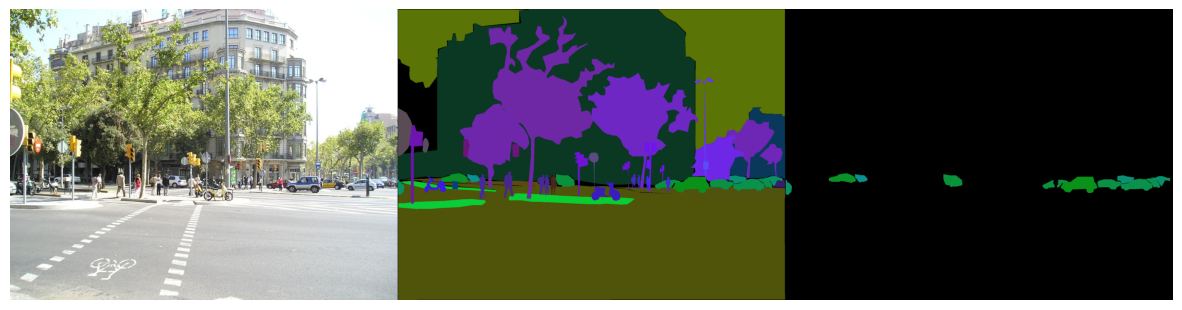

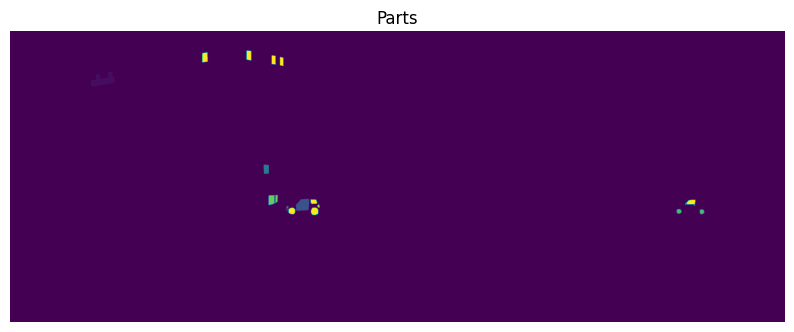

In [67]:
root_path = DATASET_PATH

# This function reads the image and mask files and generate instance and segmentation
# masks
info = utils_ade20k.loadAde20K('{}/{}'.format(root_path, full_file_name))
img = cv2.imread(info['img_name'])[:,:,::-1]
seg = cv2.imread(info['segm_name'])[:,:,::-1]
seg_mask = seg.copy()


# The 0 index in seg_mask corresponds to background (not annotated) pixels
seg_mask[info['class_mask'] != obj_id+1] *= 0
plt.figure(figsize=(15,5))

plt.imshow(np.concatenate([img, seg, seg_mask], 1))
plt.axis('off')
if len(info['partclass_mask']):
    plt.figure(figsize=(5*len(info['partclass_mask']), 5))
    plt.title('Parts')
    plt.imshow(np.concatenate(info['partclass_mask'],1))
    plt.axis('off')



You can also inspect the attributes `info['objects']` and `info['parts']` for information about object names, attributes etc.

## Amodal segmentation and Polygons
We also provide access to the original polygons annotated, as well as the amodal segmentation of object instances

定義了一個列表 instances，其中包含了要顯示的物件實例的編號。

創建了一個空的列表 images，用於存儲物件實例的圖像。

使用迴圈遍歷 instances 列表中的每個物件實例編號。

構建每個物件實例的檔案路徑，使用 root_path、full_file_name、instance 和 file_name。

使用 cv2.imread 函式讀取物件實例的圖像，並將其存儲在變數 aux 中。

將每個物件實例的圖像加入到 images 列表中。

使用 plt.figure 函式設定圖片的尺寸。

使用 np.concatenate 函式將 images 列表中的圖像連接在一起。

使用 plt.imshow 函式顯示連接後的圖像。

使用 plt.axis('off') 隱藏坐標軸。

(-0.5, 6143.5, 1535.5, -0.5)

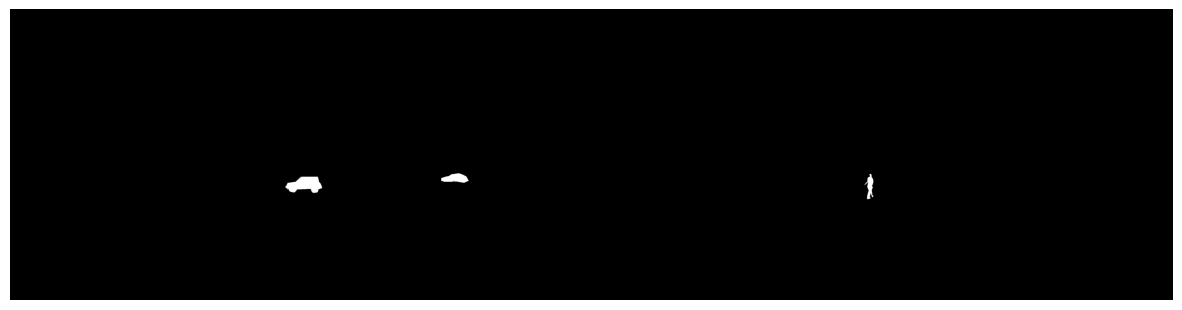

In [68]:
# We have a segmentation for every object instance, showing object bounds without occlusions
instances = [4, 10, 19]
images = []
for instance in instances:
    file_instance = '{}/{}/instance_{:03}_{}'.format(
        root_path, full_file_name.replace('.jpg', ''), instance, file_name.replace('.jpg', '.png'))
    aux = cv2.imread(file_instance)
    images.append(aux)
plt.figure(figsize=(5*len(images), 5))
plt.imshow(np.concatenate(images, 1))
plt.axis('off')

Finally we can get the original polygons

(-0.5, 2047.5, 1535.5, -0.5)

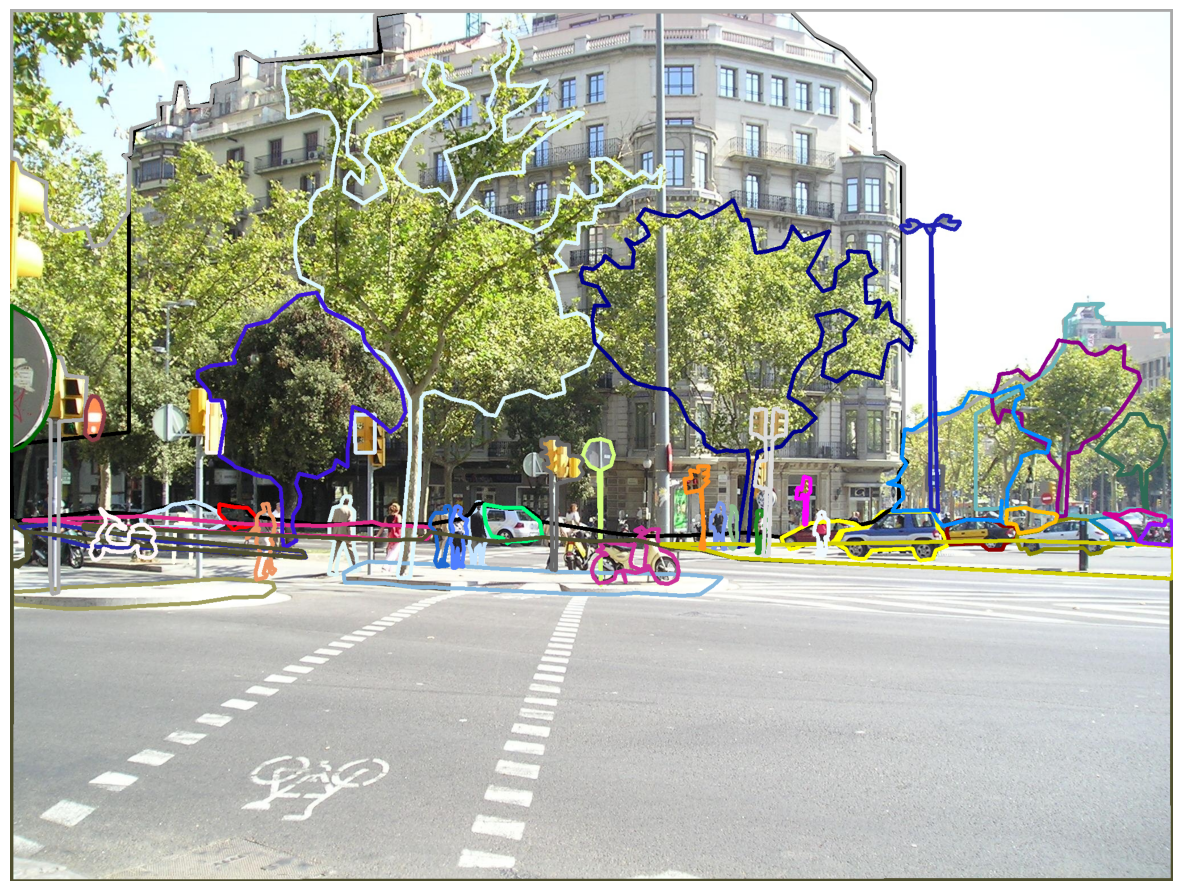

In [69]:
img = utils_ade20k.plot_polygon('{}/{}'.format(root_path, full_file_name), info)
plt.figure(figsize=(15,15))
plt.imshow(img[:, :, ::-1])
plt.axis('off')

導入必要的套件和模組，包括 TensorFlow、NumPy、datetime、matplotlib.pyplot、cv2、os、random、keras 等。

設定 %matplotlib inline，以在 Jupyter Notebook 中顯示圖片。

導入圖像增強所需的 imgaug 套件，包括 ia 和 iaa。

使用 from shutil import copyfile 導入 copyfile 函式，用於檔案的複製。

In [70]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import numpy as np

from datetime import datetime

%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import os
import random

from tensorflow import keras
from tensorflow.keras import layers

## image augmentation
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

from shutil import copyfile
import os

參數設定，用於物件偵測模型的建構和訓練

In [71]:
classes_name =  ["aeroplane", "bicycle", "bird", "boat", "bottle", 
                 "bus", "car", "cat", "chair", "cow", "diningtable", 
                 "dog", "horse", "motorbike", "person", "pottedplant", 
                 "sheep", "sofa", "train","tvmonitor"]

# common params
IMAGE_SIZE = 448
BATCH_SIZE = 8
NUM_CLASSES = 20
MAX_OBJECTS_PER_IMAGE = 20

# dataset params
PATH_TO_DATA2 = "./深度學習作業4/Object Detection"
DATA2_PATH = PATH_TO_DATA2 + 'training_data.txt'
IMAGE_DIR = PATH_TO_DATA2 + '/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages'

# model params
CELL_SIZE = 7
BOXES_PER_CELL = 2
OBJECT_SCALE = 1
NOOBJECT_SCALE = 0.5
CLASS_SCALE = 1
COORD_SCALE = 5

# training params
LEARNING_RATE = 0.01
EPOCHS = 10

is_load_best = False

PROB_THRES = 0.01
IOU_THRES = 0.3

createBarLabels(barplot) 函式：用於在垂直條形圖上標註每個條形的數值。它遍歷傳入的 barplot (條形圖) 物件，為每個條形添加數值標註。

balanced_label(data) 函式：用於計算標籤的平衡度，即各個類別在資料集中的分佈情況。它接受一個包含標籤資料的列表 data，並計算每個類別在資料集中的出現次數。返回一個列表 label_class_dist，其中每個元素包含類別的索引和出現次數。

training_data_label：打開 "train.txt" 檔案，用於讀取訓練資料的標籤。

label_class_dist：使用 balanced_label 函式計算訓練資料集中各個類別的分佈情況，並將結果存儲在 label_class_dist 列表中。

繪製垂直條形圖：使用 plt.bar 函式繪製垂直條形圖，條形的 x 軸為類別的索引，y 軸為該類別在資料集中的出現次數。同時，使用 createBarLabels 函式在每個條形上標註數值。

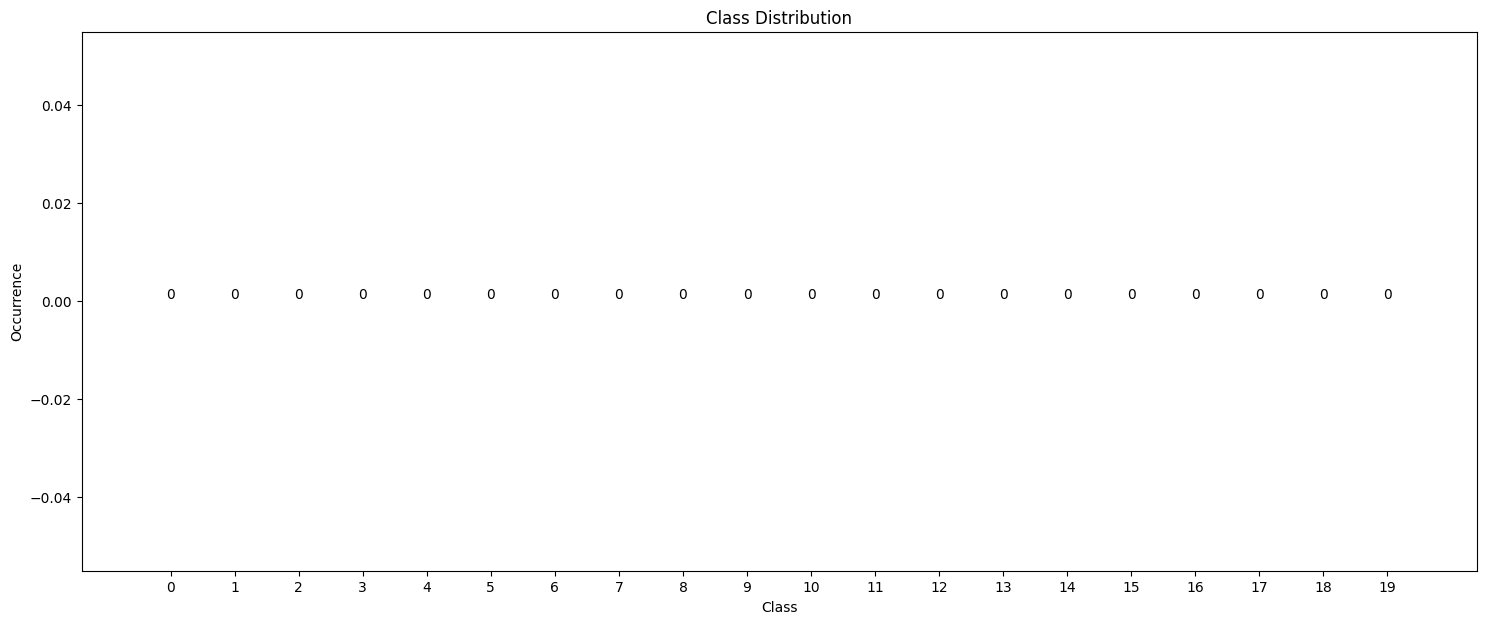

In [72]:
def createBarLabels(barplot):
    for item in barplot:
        plt.text(
            item.get_x()+item.get_width()/2., 
            item.get_height()*1.005, 
            '%d' % int(item.get_height()),
            ha = "center",
            va = "bottom",
        )

def balanced_label(data):

    label_dist = []
    for i, label_line in enumerate(data):
            label_line = label_line.strip().split()
            label_line = label_line[1:]
            length = len(label_line)//5
            for j in range(length):
                label_dist.append(label_line[j*5+4])

    label_class_dist = []

    for i, classi in enumerate(range(20)):
        label_class_dist.append((str(i), label_dist.count(str(classi))))

    return(label_class_dist)

training_data_label = open("./Object Detection/train.txt", "r")
label_class_dist = balanced_label(training_data_label)

plt.figure(figsize=(18,7))
A = plt.bar(list(zip(*label_class_dist))[0],list(zip(*label_class_dist))[1], color = '#008EC7')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Occurrence')
createBarLabels(A)

__init__(self, data)：資料集的初始化函式。接受一個 data 參數，該參數應該是包含圖像資料的列表或數組。

__len__(self)：資料集的長度，即圖像的數量。

__getitem__(self, index)：根據給定的索引 index 回傳資料集中指定索引位置的圖像。這裡假設 data 是一個包含圖像的列表，根據索引 index 從 data 中獲取對應的圖像並返回。

In [73]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.models as models

# Define your custom dataset for segmentation
class SegmentationDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image = self.data[index]  # Assuming your data is a list of images
        return image

__init__(self, num_classes_detection, num_classes_segmentation)：網路的初始化函式。接受兩個參數，num_classes_detection 和 num_classes_segmentation 分別表示物體偵測和語義分割的類別數量。

在初始化函式中，首先建立共享的基礎網路層（backbone），這裡使用了預訓練的 ResNet-50 模型。然後，移除基礎網路的全連接層，並將其替換為 nn.Identity()，以便從基礎網路中獲取特徵。接著，定義物體偵測的頭部（object detection head），該頭部是一個線性層，輸入特徵的維度為 num_features，輸出維度為 num_classes_detection。最後，定義語義分割的頭部（semantic segmentation head），該頭部是一個卷積層，輸入特徵的通道數為 num_features，輸出通道數為 num_classes_segmentation。

forward(self, x)：網路的前向傳播函式。將輸入 x 通過共享的基礎網路層獲取特徵，然後分別將特徵輸入物體偵測頭部和語義分割頭部，得到物體偵測和語義分割的輸出。

以下程式碼創建了 DualTaskNetwork，並使用 DataLoader 加載物體偵測和語義分割的資料集。然後，定義了物體偵測和語義分割任務的優化器，分別針對物體偵測頭部和語義分割頭部的參數進行優化。接著，進行了訓練迴圈，根據迴圈的當前 epoch 和任務切換的條件，選擇適當的優化器、圖像和目標。然後，將圖像和目標移動到適當的裝置（例如 GPU），進行前向傳播、計算任務特定的損失、反向傳播和優化。最後，列印出損失和其他評估指標。

In [74]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.models as models

# Define your network architecture
class DualTaskNetwork(nn.Module):
    def __init__(self, num_classes_detection, num_classes_segmentation):
        super(DualTaskNetwork, self).__init__()
        
        # Define the shared base network layers (backbone)
        self.backbone = models.resnet50(pretrained=True)
        num_features = self.backbone.fc.in_features
        
        # Remove the fully connected layer from the backbone
        self.backbone.fc = nn.Identity()
        
        # Define the object detection head
        self.object_detection_head = nn.Linear(num_features, num_classes_detection)
        
        # Define the semantic segmentation head
        self.semantic_segmentation_head = nn.Conv2d(num_features, num_classes_segmentation, kernel_size=1)

    def forward(self, x):
        # Forward pass through the shared backbone
        features = self.backbone(x)
        
        # Forward pass through the object detection head
        detection_output = self.object_detection_head(features)
        
        # Forward pass through the semantic segmentation head
        segmentation_output = self.semantic_segmentation_head(features)
        
        return detection_output, segmentation_output

    
# Create your network instance
network = DualTaskNetwork(20, 150)

# Modify the dataloader for separate datasets
detection_dataset = IMAGE_DIR
segmentation_dataset = img  # Create a custom dataset


detection_dataloader = DataLoader(detection_dataset, batch_size=28, shuffle=True)
segmentation_dataloader = DataLoader(segmentation_dataset, batch_size=28, shuffle=True)
print(segmentation_dataloader)


# Define your optimizers for each task
optimizer_detection = optim.Adam(network.object_detection_head.parameters(), lr=0.01)
optimizer_segmentation = optim.Adam(network.semantic_segmentation_head.parameters(), lr=0.01)

# Training loop
for epoch in range(10):
    for step, data in enumerate(detection_dataloader):
        detection_images, detection_targets = data
        
        # Get segmentation data for the current step
        segmentation_data = next(iter(segmentation_dataloader))
        segmentation_images, segmentation_targets = segmentation_data
        
        # Switch between tasks
        if epoch % 2 == 0:
            optimizer = optimizer_detection
            task_images, task_targets = detection_images, detection_targets
        else:
            optimizer = optimizer_segmentation
            task_images, task_targets = segmentation_images, segmentation_targets
        
        # Move images and targets to the appropriate device (e.g., GPU)
        task_images = task_images.to(device)
        task_targets = task_targets.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        detection_output, segmentation_output = network(task_images)
        
        # Compute task-specific losses
        detection_loss = compute_detection_loss(detection_output, task_targets['detection'])
        segmentation_loss = compute_segmentation_loss(segmentation_output, task_targets['segmentation'])
        
        # Compute total loss
        total_loss = detection_loss + segmentation_loss
        
        # Backward pass and optimization
        total_loss.backward()
        optimizer.step()
        
        # Print the losses and other metrics
        print(f"Epoch [{epoch+1}/{num_epochs}], Step: [{step+1}/{total_steps}], "
              f"Total Loss: {total_loss.item()}, Detection Loss: {detection_loss.item()}, "
              f"Segmentation Loss: {segmentation_loss.item()}")


ValueError: too many values to unpack (expected 2)

In [75]:
targets.shape

torch.Size([28, 2048, 3])

In [76]:
print(targets)

tensor([[[ 47,  79,  79],
         [ 47,  79,  79],
         [ 47,  79,  79],
         ...,
         [ 47,  79,  79],
         [ 47,  79,  79],
         [ 47,  79,  79]],

        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [189, 183, 107],
         [189, 183, 107],
         [189, 183, 107]],

        [[169, 169, 169],
         [169, 169, 169],
         [169, 169, 169],
         ...,
         [169, 169, 169],
         [169, 169, 169],
         [169, 169, 169]],

        ...,

        [[  0, 100,   0],
         [  0, 100,   0],
         [  0, 100,   0],
         ...,
         [189, 183, 107],
         [189, 183, 107],
         [189, 183, 107]],

        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [189, 183, 107],
         [189, 183, 107],
         [189, 183, 107]],

        [[ 47,  79,  79],
         [ 47,  79,  79],
         [ 47,  79,  79],
         ...,
         [ 47,  79,  79],
        

In [77]:
img.shape

(1536, 2048, 3)